In [1]:
import ollama
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
newsgroup_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroup_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [4]:
train_data = newsgroup_train.data
train_labels = newsgroup_train.target

test_data = newsgroup_test.data
test_labels = newsgroup_test.target

print(f"Number of train docs: {len(train_data)}")
print(f"Number of test docs: {len(test_data)}")
print(f"Number of classes: {len(newsgroup_train.target_names)}")

lengths_training = [len(doc.split()) for doc in train_data]
print(f"Avg words per doc in training data: {sum(lengths_training)/len(lengths_training): .2f}")
lenghts_test = [len(doc.split()) for doc in test_data]
print(f"Avg words per doc in test data: {sum(lenghts_test)/len(lenghts_test): .2f}")

Number of train docs: 11314
Number of test docs: 7532
Number of classes: 20
Avg words per doc in training data:  185.83
Avg words per doc in test data:  175.34


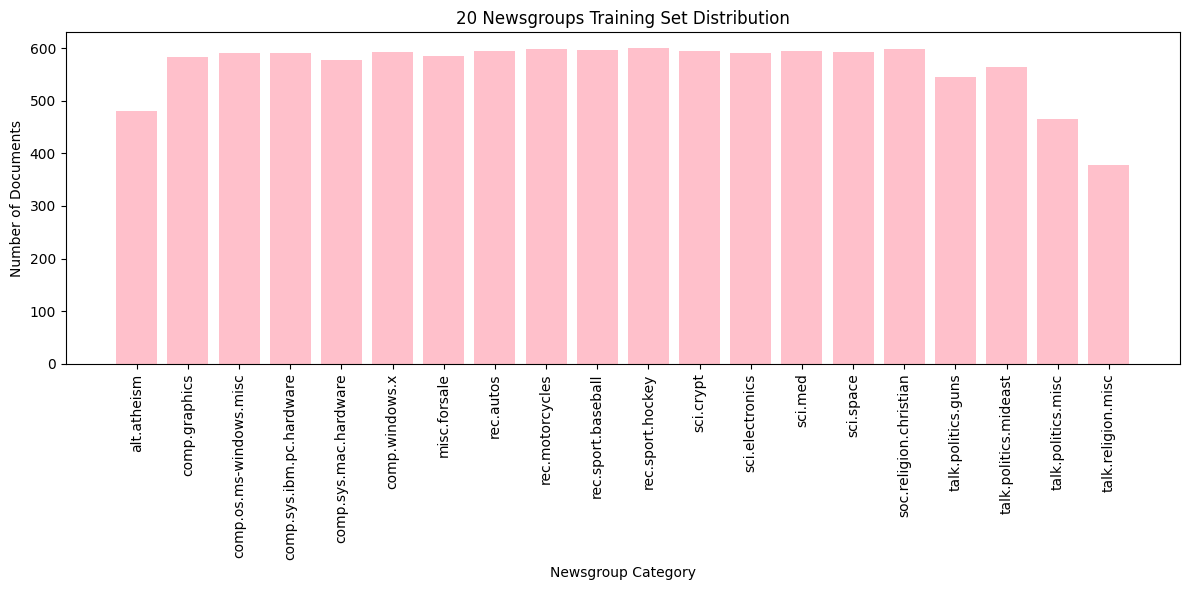

In [5]:
unique, counts = np.unique(newsgroup_train.target, return_counts = True)
class_names = newsgroup_train.target_names
plt.figure(figsize=(12,6))
plt.bar(class_names, counts, color='pink')
plt.xticks(rotation=90)
plt.xlabel('Newsgroup Category')
plt.ylabel('Number of Documents')
plt.title('20 Newsgroups Training Set Distribution')
plt.tight_layout()
plt.show()

In [6]:
print(class_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000, sublinear_tf=True, min_df=2, max_df=0.8, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data)
X_test_tfidf = tfidf_vectorizer.transform(test_data)

In [8]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [9]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names= class_names):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
    print("Recall (macro): ", recall_score(y_test, y_pred, average='macro'))
    print("F1-Score (macro): ", f1_score(y_test, y_pred, average='macro'))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
    print("-"*50)

In [10]:
svm = LinearSVC()
evaluate_model(svm, X_train_tfidf, train_labels, X_test_tfidf, test_labels)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rfc, X_train_tfidf, train_labels, X_test_tfidf, test_labels)

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
evaluate_model(mlp, X_train_tfidf, train_labels, X_test_tfidf, test_labels)

Model: LinearSVC
Accuracy: 0.6591874668082847
Precision (macro): 0.6554682971015618
Recall (macro):  0.6480299622021588
F1-Score (macro):  0.6483846254627414

Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.49      0.45      0.47       319
           comp.graphics       0.61      0.66      0.64       389
 comp.os.ms-windows.misc       0.59      0.61      0.60       394
comp.sys.ibm.pc.hardware       0.58      0.59      0.59       392
   comp.sys.mac.hardware       0.68      0.66      0.67       385
          comp.windows.x       0.79      0.68      0.73       395
            misc.forsale       0.74      0.77      0.76       390
               rec.autos       0.71      0.66      0.68       396
         rec.motorcycles       0.74      0.70      0.72       398
      rec.sport.baseball       0.52      0.80      0.63       397
        rec.sport.hockey       0.85      0.86      0.85       399
               sci.crypt

In [11]:
from lime.lime_text import LimeTextExplainer
class_names = fetch_20newsgroups().target_names
explainer = LimeTextExplainer(class_names= class_names)
def predict_proba(texts):
    tfidf_vectors = tfidf_vectorizer.transform(texts)
    return rfc.predict_proba(tfidf_vectors)
doc_id = 10 
document = test_data[doc_id]
label = test_labels[doc_id]

exp = explainer.explain_instance(document, predict_proba, num_features = 10, top_labels= 1)

print("Printed Label: ", class_names[rfc.predict(tfidf_vectorizer.transform([document]))[0]])
print("True label: ", class_names[label])

Printed Label:  comp.os.ms-windows.misc
True label:  comp.os.ms-windows.misc



 Document ID: 10
Predicted Lable: comp.os.ms-windows.misc
True Label: comp.os.ms-windows.misc

 Top 10 influential words and their weights: 

Windows              +0.2439 (Positive)
cica                 +0.1898 (Positive)
ftp                  +0.0716 (Positive)
win3                 +0.0682 (Positive)
indiana              +0.0442 (Positive)
edu                  +0.0423 (Positive)
pc                   +0.0389 (Positive)
zip                  +0.0219 (Positive)
pub                  +0.0144 (Positive)
Review               -0.0115 (Negative)
Predicted: comp.os.ms-windows.misc, True: comp.os.ms-windows.misc


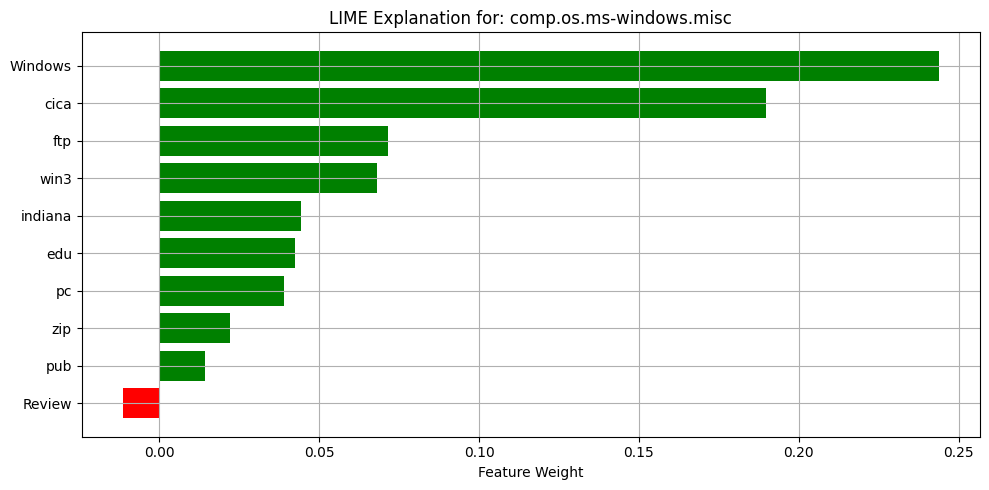

In [12]:
top_label = exp.top_labels[0]
weights = exp.as_list(label=top_label)

print(f"\n Document ID: {doc_id}")
print(f"Predicted Lable: {class_names[svm.predict(tfidf_vectorizer.transform([document]))[0]]}")
print(f"True Label: {class_names[test_labels[doc_id]]}")
print(f"\n Top 10 influential words and their weights: \n")

for word, weight in exp.as_list(label= top_label):
    influence = "Positive" if weight > 0 else "Negative"
    print(f"{word:<20} {weight:+.4f} ({influence})")

df = pd.DataFrame(weights, columns=['Word', 'Weight'])
df['Contribution'] = df['Weight'].apply(lambda w: 'Positive(+)' if w>0 else 'Negative(-)')

print(f"Predicted: {class_names[top_label]}, True: {class_names[test_labels[doc_id]]}")
df.style.bar(subset='Weight', align='mid').set_caption("Top Influential Words for Prediction")

words, weights = zip(*exp.as_list(label=top_label))
colors= ['green' if w > 0 else 'red' for w in weights]

#words, weights_only = zip(*weights)
#colors = ['green' if w > 0 else 'red' for w in weights_only]

plt.figure(figsize=(10,5))
plt.barh(words, weights, color=colors)
plt.xlabel("Feature Weight")
plt.title(f"LIME Explanation for: {class_names[top_label]}")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data
labels = newsgroups.target
class_names = newsgroups.target_names

c:\Users\kanik\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
model = SentenceTransformer('all-MiniLM-L6-v2') 

# Get sentence embeddings
embeddings = model.encode(documents, show_progress_bar=True)

Batches: 100%|██████████| 589/589 [11:31<00:00,  1.17s/it]


In [15]:
X_train, X_test, y_train, y_test, docs_train, docs_test = train_test_split(
    embeddings, labels, documents, test_size=0.2, random_state=42)

In [16]:
from sklearn.calibration import CalibratedClassifierCV
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
import numpy as np

def run_and_explain_model(model, model_name, sbert_model, doc_id=10):
    from lime.lime_text import LimeTextExplainer
    import matplotlib.pyplot as plt

    # Wrap SVC for probability support
    if model_name.lower().startswith("linear svc"):
        from sklearn.calibration import CalibratedClassifierCV
        model = CalibratedClassifierCV(model)

    model.fit(X_train, y_train)

    # LIME prediction wrapper
    def predict_proba_sbert(texts):
        vectors = sbert_model.encode(texts)
        return model.predict_proba(vectors)

    explainer = LimeTextExplainer(class_names=class_names)
    doc = docs_test[doc_id]
    true_label = y_test[doc_id]

    exp = explainer.explain_instance(doc, predict_proba_sbert, num_features=10, top_labels=1)
    top_label = exp.top_labels[0]

    print(f"\nModel: {model_name}")
    print(f"Document ID: {doc_id}")
    print(f"Predicted: {class_names[model.predict([X_test[doc_id]])[0]]}")
    print(f"True: {class_names[true_label]}")
    print("\nTop influential words:")
    for word, weight in exp.as_list(label=top_label):
        print(f"{word:<20} {weight:+.4f}")

    # Plot
    words, weights = zip(*exp.as_list(label=top_label))
    colors = ['green' if w > 0 else 'red' for w in weights]

    plt.figure(figsize=(10, 5))
    plt.barh(words, weights, color=colors)
    plt.xlabel("Feature Weight")
    plt.title(f"{model_name} - LIME Explanation")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("-"*50)



Model: Random Forest
Document ID: 10
Predicted: comp.graphics
True: comp.graphics

Top influential words:
graphics             +0.1155
comp                 +0.0349
c                    +0.0299
s                    -0.0156
talking              +0.0156
not                  -0.0124
I                    +0.0114
Only                 -0.0083
amiga                -0.0053
that                 +0.0043


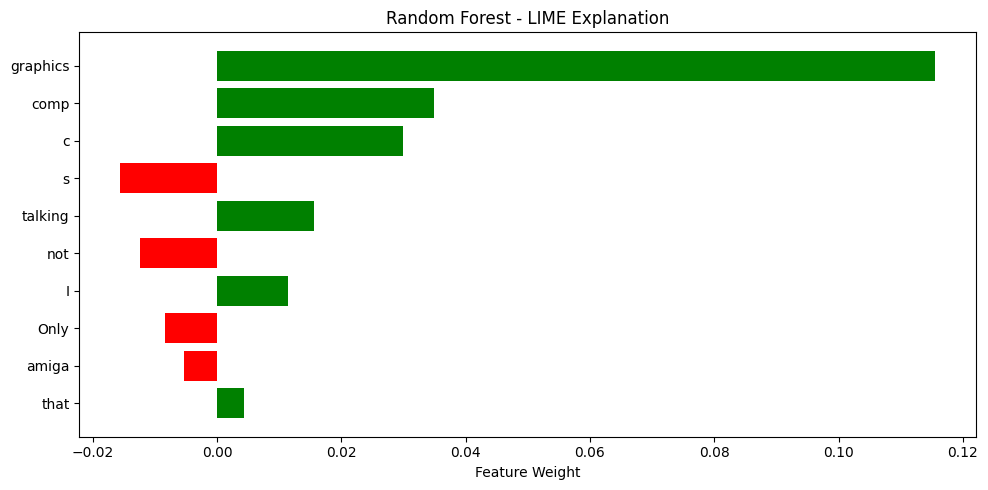

--------------------------------------------------


c:\Users\kanik\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Model: MLP Classifier
Document ID: 10
Predicted: comp.graphics
True: comp.graphics

Top influential words:
graphics             +0.5752
amiga                +0.1794
about                +0.0893
s                    +0.0529
comp                 -0.0437
c                    +0.0363
we                   +0.0338
Maybe                +0.0229
not                  -0.0205
point                +0.0179


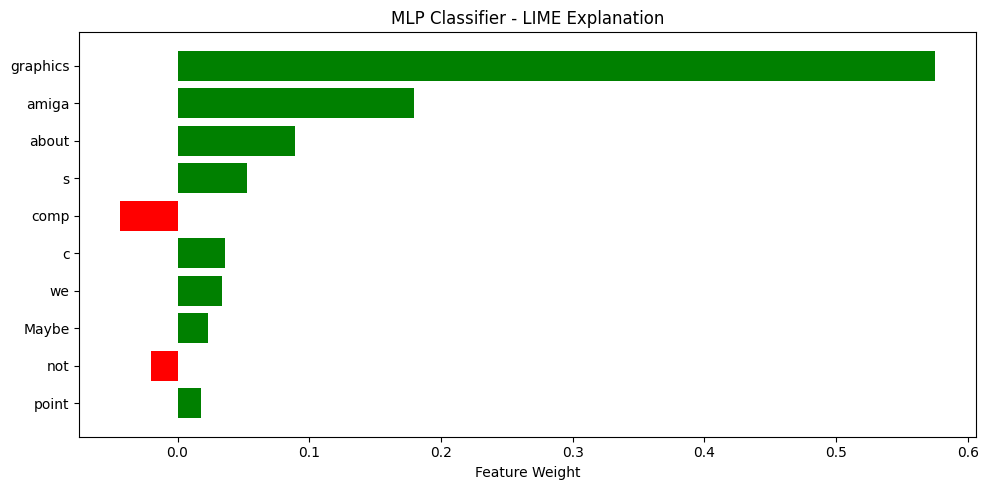

--------------------------------------------------

Model: Linear SVC
Document ID: 10
Predicted: comp.graphics
True: comp.graphics

Top influential words:
graphics             +0.6169
comp                 -0.0599
about                +0.0395
s                    +0.0369
amiga                -0.0347
point                +0.0307
Only                 -0.0265
not                  -0.0140
c                    +0.0124
Maybe                +0.0090


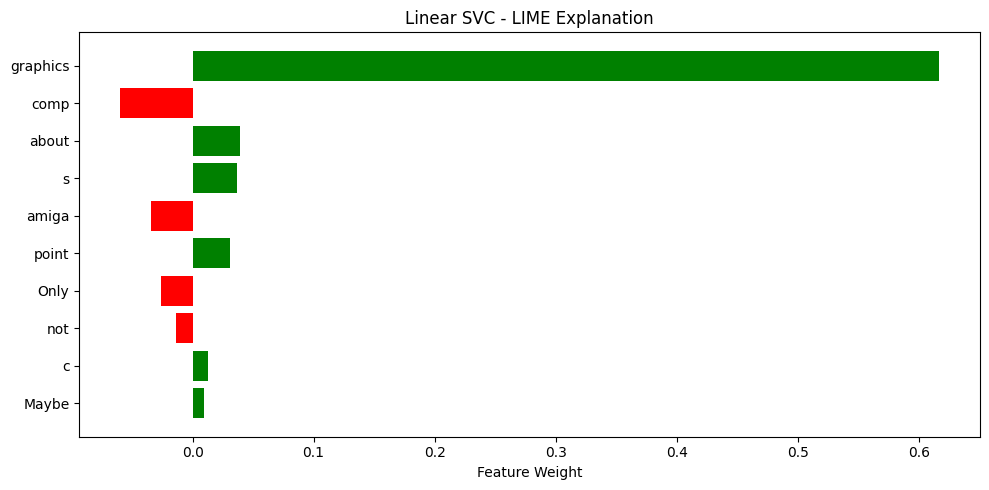

--------------------------------------------------


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sentence_transformers import SentenceTransformer

# Load a pre-trained Sentence-BERT model
sbert = SentenceTransformer('all-MiniLM-L6-v2')
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "Linear SVC": LinearSVC(max_iter=2000, random_state=42)
}

# Run each model
for name, model in models.items():
    run_and_explain_model(model, model_name=name, sbert_model=sbert, doc_id=10)
